# Classification and Clustering

> "Machine learning’s applications have exploded too suddenly for education to keep up, and it [machine learning] has a reputation for being a difficult subject. Textbooks are liable to give you math indigestion. This difficulty is more apparent than real, however.  All of the important ideas in machine learning can be expressed math-free."

> Pedro Domingos, *The Master Algorithm*

> Department of Computer Science & Engineering, The University of Washington 

In [1]:
# Load the libraries.  Everyone should pip install tabulate.  
# Anaconda automatically installs sklearn.

%matplotlib inline
import warnings
import numpy as np
import pandas as pd
from numpy import random
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
#import Quandl
import statsmodels as sm
import statsmodels.formula.api as smf
import statsmodels.api as sma
import patsy
from statsmodels.graphics.api import abline_plot
import numpy.linalg as linalg
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets
from tabulate import tabulate
warnings.simplefilter('ignore')
sns.set(context='notebook', style='whitegrid', palette='deep', font='sans-serif', font_scale=1, rc=None)
from pylab import get_cmap

## Classification

Very frequently, we have categorical labels in our data, together with features (also called predictors or explanatory variables).  We have already seen an example of this with the logit classifier, where we observed whether or not something occurred based on the realization of a latent index.  The observation was $\{0, 1\}$ or $\{$not observed, observed$\}$.  We saw how it is straightforward to develop a likelihood surface to optimize.  

Another class of statistical learning questions is called classification.  What we seek is a predictor function, $pred$, for a label using $K$ features, $x$:

$y_i = pred(x_{i1}, ..., x_{iK})$.

The realization of this predictor, given a feature set, is sometimes called "yhat" or $\hat{y}$.

It is easy to visualize conceptually the nature of this class of questions with scatterplots. 

In [2]:
# Generate some data for scatterplots.

random.seed(12345)
red = np.random.multivariate_normal([-1, 1], [[1,0],[0,1]], 1000)
blue = np.random.multivariate_normal([1, -1], [[1,0],[0,1]], 1000)

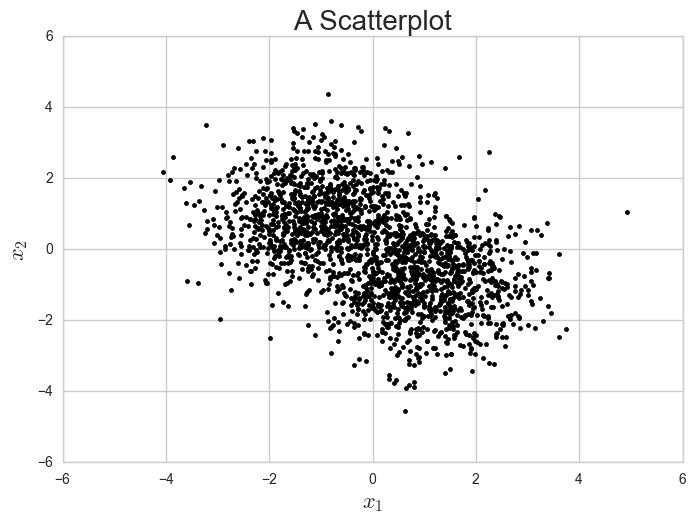

In [3]:
#plt.figure(figsize=(10,8))
plt.plot(red, blue, 'k.')
plt.xlim(-6, 6)
plt.ylim(-6, 6)
plt.xlabel(r'$x_1$', fontsize = 16)
plt.ylabel(r'$x_2$', fontsize = 16)
plt.title(r'A Scatterplot', fontsize = 20)

This scatterplot should be quite familiar by now.  We have two features, the pair $(x_1, x_2)$, and some label (or outcome), which could be anything.    

But suppose that the dots were of two flavors, $\{$red, blue$\}$.  That is, the dataframe contains three columns, a label and two features: [flavor, $x_1$, $x_2$].  For example, [red, -2, 2].

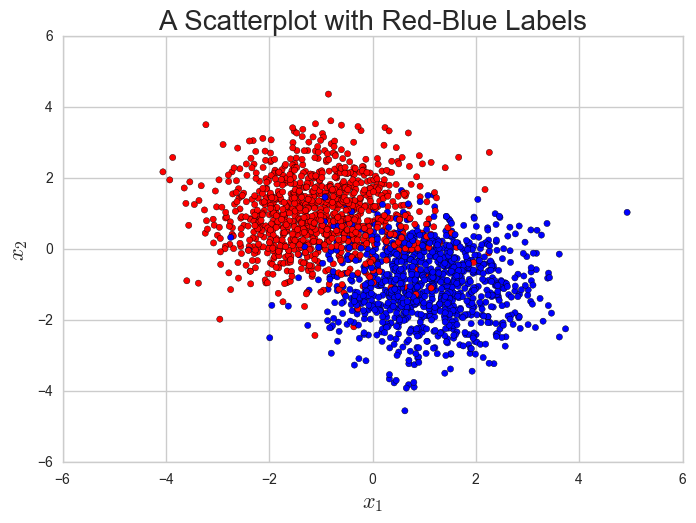

In [4]:
#plt.figure(figsize=(10,8))
colors = ['red', 'blue']
plt.scatter(red, blue, c=colors)
plt.xlim(-6, 6)
plt.ylim(-6, 6)
plt.xlabel(r'$x_1$', fontsize = 16)
plt.ylabel(r'$x_2$', fontsize = 16)
plt.title(r'A Scatterplot with Red-Blue Labels', fontsize = 20)

- Classification involves developing statistical learning models that can be used for the purpose of prediction (or as "predictors").  Namely, suppose we have a sample of data of size $N$ for which we observe [flavor, $x_1$, $x_2$].  We can split the sample into a "training set" of size $N_1$ and a "test set" of size $N_2$, such that $N_1+N_2=N$.  

- As should be clear from the names of the samples, we train our model using the training data.  We then assess the performance of our predictor on the test data because we can compare the label that our model predicts with the $correct$ (or true) label.

    - For many in the ML community, out of sample prediction is the only test of model validation.

- Ultimately, we may wish to predict "out of sample".  Namely, if we have an a feature pair $(x_1, x_2)$ that has no label, we could predict the label based on our model.  

- Look at the scatterplot above.  Notice that there is a clear delineation between the red and blue labels.  Indeed, you can almost create mentally a boundary separating the two clusters of labels.  

- Suppose you were given a feature vector of (4.2, -1.8) without a label.  What label would you attach to this unlabeled observation?

- Suppose you were given a feature vector of (-2.3, -3.9) without a label.  What label would you attach to this unlabeled observation?

- Suppose you were given a feature vector of (0, 0) without a label.  What label would you attach to this unlabeled observation?

- This is the essence of statistical learning for classification.  

- We will begin where we ended (pre Bayesian): the logit classifier.  This statistical learning model can easily become a classifier, the logit classifier.  We will then walk through a number of different classifiers used in computer science and economics.  They are K Nearest Neighbors, Random Forest, Linear Discriminant Analysis, Multinomial Logit, and Naive Bayes.  

- The focus will follow the quote above, emphasizing what they do (and how to use them) rather than on the mathematics that underlies them.

### The Logit Classifier

Recall the stochastic model.

$Pr(d_i=1)=x_i^\prime\beta+\epsilon_i$, where $\epsilon_i \sim logistic$.

We have already discussed the logit classifier as a statistical learning tool when we have a categorical label with two possible values.  As such, it is a basic tool of classification.  

### Illustrative Example: Email Spam  

> "Spamming remains economically viable because advertisers have no operating costs beyond the management of their mailing lists, and it is difficult to hold senders accountable for their mass mailings. Because the barrier to entry is so low, spammers are numerous, and the volume of unsolicited mail has become very high. In the year 2011, the estimated figure for spam messages is around seven trillion. The costs, such as lost productivity and fraud, are borne by the public and by Internet service providers, which have been forced to add extra capacity to cope with the deluge."  

> "Spam ... grew exponentially... and today composes [comprises] some 80 to 85 percent of all the e-mail in the World, by a 'conservative estimate'."

> Source: Wikipedia.

We are going to classify email spam using a well-known University of California-Irvine (UCI) machine learning database called "spambase".  Here, $d_i=1$ is "spam", and $d_i=0$ is "not spam" (or valid email).

The steps to deploy the logit as a classifier are as follows:

1. Read in the data and create a dataframe.
2. Split at random the dataframe into training and test sets.
3. Estimate the logit model on the training set to obtain $\hat{\beta}$, the maximum likelihood estimates of $\beta$ given the training set.
4. Using $\hat{\beta}$, obtain predictions using the test set.  Recall that these predictions will lie between 0 and 1.  
5. Based on a **threshold of our choosing**, classify the observations in the test set as "spam" or "not spam".  This threshold is typically called a "discriminant threshold".
6. Compare our predicted classifications to the correct (or true) classifications in the test set.  
7. Develop a "confusion" (or error) matrix.
8. Calculate measures of precision.

In [5]:
# 1. Read in the data.

target_url = ("https://archive.ics.uci.edu/ml/machine-learning-databases/"
              "spambase/spambase.data")

# Read spam data from UCI repository.
spam = pd.read_csv(target_url, header=None, prefix="v")

# Note that R indexes from 1, while Python indexes from 0.
# Spam indicator is v57.  Rename it.
spam.rename(columns={'v57':'spam'}, inplace=True)
print (spam['spam'].head())
print (spam['spam'].tail())

0    1
1    1
2    1
3    1
4    1
Name: spam, dtype: int64
4596    0
4597    0
4598    0
4599    0
4600    0
Name: spam, dtype: int64


In [6]:
# 2. Randomly split the dataframe as 2/3rds train and 1/3rd test.
# Earlier I showed one method to split samples using random draws from uniform(0, 1), which is coded below.  
# For an alternative approach, see pandas.DataFrame.sample().

np.random.seed(12345)
spam['index'] = np.random.uniform(low = 0, high = 1, size = len(spam))
spam['test'] = pd.get_dummies(spam['index'] <= 0.3333)[1]

# We don't need the index, so drop it.
del spam['index']

# Now we can create new train and test dataframes.
# Note the format of these command lines.
# It basically resolves as create spamtest as a subset of spam when test is 1.
# Otherwise, it is train.
spamtest = spam[spam['test'] == 1]
spamtrain = spam[spam['test'] == 0]

# Confirm data has been split properly.
print(len(spamtrain))
print(len(spamtest))
print(len(spam))

3056
1545
4601


In [7]:
# 3 and 4.  Estimate the logit with the first five features.
# Note that Statsmodels generates the predicted values as an numpy array.  
# Create a variable in the spamtest dataframe equal to predicted values.

logit_mod = smf.logit('spam ~ v0 + v1 + v2 + v3 + v4', data = spamtrain).fit()
print()
print(logit_mod.summary())
pred = np.array(logit_mod.predict(spamtest))
spamtest['pred'] = logit_mod.predict(spamtest)

Optimization terminated successfully.
         Current function value: 0.608677
         Iterations 12

                           Logit Regression Results                           
Dep. Variable:                   spam   No. Observations:                 3056
Model:                          Logit   Df Residuals:                     3050
Method:                           MLE   Df Model:                            5
Date:                Wed, 19 Apr 2017   Pseudo R-squ.:                 0.09162
Time:                        10:20:53   Log-Likelihood:                -1860.1
converged:                       True   LL-Null:                       -2047.7
                                        LLR p-value:                 6.441e-79
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -1.0253      0.053    -19.426      0.000        -1.129    -0.922
v0             0.7213      

In [8]:
# With a logit predictor, you can correctly predict a 1 or correctly predict 0.
# Obviously, you can incorrectly predict a 1 or incorrectly predict a 0.
# This is the basis of the confusion matrix, together with other measures of accuracy.

print("What is a confusion matrix, and what might we do with its elements?")
print()
table = [[" ","0", "1"],["0", "TN", "FP"],["1", "FN", "TP"]]
print(tabulate(table, tablefmt="fancy_grid", numalign = "center"))
print()

print("The True Positive Rate is TP / (TP + FN)") 
print("The False Positive Rate is FP / (TN + FP)")
print("The Accuary Rate is (TN + TP) / (TN + FP + FN + TP)")
print("The Mean Squared Error is the Average Squared Deviation Between the Truth and Our Prediction")

What is a confusion matrix, and what might we do with its elements?

╒═══╤════╤════╕
│   │ 0  │ 1  │
├───┼────┼────┤
│ 0 │ TN │ FP │
├───┼────┼────┤
│ 1 │ FN │ TP │
╘═══╧════╧════╛

The True Positive Rate is TP / (TP + FN)
The False Positive Rate is FP / (TN + FP)
The Accuary Rate is (TN + TP) / (TN + FP + FN + TP)
The Mean Squared Error is the Average Squared Deviation Between the Truth and Our Prediction


### The Mean Squared Error and Bias/Variance Decomposition

For any predictor, $\hat{y}$, of label, $y$, with a dataframe of size $N$, the MSE ${\displaystyle =\frac{1}{N}\sum_{i=1}^N(y_i - \hat{y_i})^2}$.

In words, the MSE is the average of the squared deviations between our prediction and the truth.  We have already seen this.  Without the $\frac{1}{N}$, this is the Sum of Squared Residuals function, $SSR(\beta)$, that we minimized with the linear regression model.  We simply normalize it by the dataframe size (which does not alter the optimal values of $\beta$).  

In practice, we do not much care about the overall MSE, but the MSE associated with the test set, in which case we simply limit the calculation to the test set.  

It can be shown with some basic algebra that the MSE can be decomposed.  Namely,

$MSE \propto Var(\hat y) + Bias(\hat y)$

What do the variance and bias of a statistical learning method measure? Variance refers to the amount by which $\hat y$ would change if we estimated it using a different training set.  Since the training data are used to fit the statistical learning method, different training data sets will result in a different $\hat y$.  The ideal $\hat y$ should not vary too much between training sets because a method which has high variance implies that small changes in the training set can result in large changes in $\hat{y}$.  **In general, more flexible statistical methods have higher variance.**  

Bias refers to the error that is introduced by approximating a real-life problem, which may be extremely complicated, by a simple representation.  For example, linear regression assumes that there is a linear relationship between between the label and the features.  It is unlikely that any real-life problem truly has such a simple linear relationship, and so performing linear regression will undoubtedly result in some bias in the estimate of $\hat{y}$.  **In general, more flexible statistical methods result in less bias.**

This is called the bias-variance tradeoff, **and it is inherent in any machine learning method**.  

- Consider a clock that is always an hour fast.  It has large bias, but low (or no) variance.  

- Consider a clock that tells the time accurately, but has random noise introduced every minute.  It has low (or no) bias, but large variance.  

In [9]:
# 5. Start with a threshold.  Initially, assume a naive threshold of 0.5.  In other words,
# it's 50-50 whether an email is spam.
# 6. Compare our predicted classifications to the correct (or true) classifications in the test set.  
# 7. Develop a "confusion" (or error) matrix.
# 8. Calculate measures of precision.

threshold = 0.5
actual = spamtest['spam'].as_matrix(columns=None)
actual.astype(int)
prediction = np.zeros((len(spamtest),), dtype=np.int)
for i in range(len(prediction)): 
    if pred[i] > threshold: prediction[i] += 1

TP = 0
FP = 0
TN = 0
FN = 0

for i in range(len(prediction)):
    if actual[i] == 0:
        if prediction[i] == 0: TN += 1
        else: FP += 1    
    if actual[i] == 1:
        if prediction[i] == 0: FN += 1
        else: TP += 1

TPR = TP / (TP + FN)
FPR = FP / (TN + FP)
ACC = (TN + TP) / (TN + FP + FN + TP)
MSE = np.sum((actual - prediction)**2) / len(prediction)

table = [[" ","0", "1"],["0", TN, FN],["1", FP, TP]]
print("The confusion matrix is:")
print(tabulate(table, tablefmt="fancy_grid", numalign = "center"))
print()
print("The True Positive Rate is", TPR) 
print("The False Positive Rate is", FPR)
print("The Accuracy Rate is", ACC)
print("The Mean Squared Error is", MSE)

The confusion matrix is:
╒═══╤═════╤═════╕
│   │  0  │  1  │
├───┼─────┼─────┤
│ 0 │ 832 │ 408 │
├───┼─────┼─────┤
│ 1 │ 101 │ 204 │
╘═══╧═════╧═════╛

The True Positive Rate is 0.3333333333333333
The False Positive Rate is 0.1082529474812433
The Accuracy Rate is 0.6705501618122978
The Mean Squared Error is 0.329449838188


In [10]:
# Not surprisingly, sklearn has libraries to do this for us.
# Call the confusion matrix and MSE libraries.

from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error

cm = confusion_matrix(actual, prediction)
MSE = mean_squared_error(actual, prediction)

TN, FP, FN, TP = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
TPR = TP / (TP + FN)
FPR = FP / (TN + FP)
ACC = (TN + TP) / (TN + FP + FN + TP)

table = [[" ","0", "1"],["0", TN, FN],["1", FP, TP]]
print("The confusion matrix is:")
print(tabulate(table, tablefmt="fancy_grid", numalign = "center"))
print()
print("The True Positive Rate is", TPR) 
print("The False Positive Rate is", FPR)
print("The Accuracy Rate is", ACC)
print("The Mean Squared Error is", MSE)

# Small differences are due to floating point representations.

The confusion matrix is:
╒═══╤═════╤═════╕
│   │  0  │  1  │
├───┼─────┼─────┤
│ 0 │ 832 │ 408 │
├───┼─────┼─────┤
│ 1 │ 101 │ 204 │
╘═══╧═════╧═════╛

The True Positive Rate is 0.333333333333
The False Positive Rate is 0.108252947481
The Accuracy Rate is 0.670550161812
The Mean Squared Error is 0.329449838188


In [11]:
# Clearly, the naive threshold is just that, naive.  
# Instead use as a threshold the incidence of spam in training set.

threshold = spamtrain['spam'].describe()[1]
prediction = np.zeros((len(spamtest),), dtype=np.int)
for i in range(len(prediction)): 
    if pred[i] > threshold: prediction[i] += 1

cm = confusion_matrix(actual, prediction)
MSE = mean_squared_error(actual, prediction)

TN, FP, FN, TP = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
TPR = TP / (TP + FN)
FPR = FP / (TN + FP)
ACC = (TN + TP) / (TN + FP + FN + TP)

table = [[" ","0", "1"],["0", TN, FN],["1", FP, TP]]
print("The confusion matrix is:")
print(tabulate(table, tablefmt="fancy_grid", numalign = "center"))
print()
print("The True Positive Rate is", TPR) 
print("The False Positive Rate is", FPR)
print("The Accuracy Rate is", ACC)
print("The Mean Squared Error is", MSE)

The confusion matrix is:
╒═══╤═════╤═════╕
│   │  0  │  1  │
├───┼─────┼─────┤
│ 0 │ 733 │ 237 │
├───┼─────┼─────┤
│ 1 │ 200 │ 375 │
╘═══╧═════╧═════╛

The True Positive Rate is 0.612745098039
The False Positive Rate is 0.21436227224
The Accuracy Rate is 0.71715210356
The Mean Squared Error is 0.28284789644


In [12]:
# This is straightforward to automate the evaluation of TPR and FPR at a number of different thresholds.
# In signal processing, this is called the Receiver Operating Characteristic (ROC) Curve.
# The ROC Curve traces out two types of error as we vary the threshold discriminant value. 
# The TPR is the sensitivity: the fraction of spam emails that are correctly identified, using a given threshold. 
# The FPR is the fraction of non-spam emails that we classify incorrectly as spam at the same threshold. 

def ROC(actual, pred, scores):
    
    tpr = np.zeros((len(scores),), dtype=np.float)
    fpr = np.zeros((len(scores),), dtype=np.float)
    acc = np.zeros((len(scores),), dtype=np.float)
    mse = np.zeros((len(scores),), dtype=np.float)
    
    for i in range(len(scores)):
        prediction = np.zeros((len(pred),), dtype=np.int)
        for j in range(len(prediction)):
            if pred[j] > scores[i]: prediction[j] += 1
                
        cm = confusion_matrix(actual, prediction)
        ms = mean_squared_error(actual, prediction)
        TN, FP, FN, TP = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
        tpr[i] = TP/(TP + FN)
        fpr[i] = FP/(TN + FP)
        acc[i] = (TN + TP) / (TN + FP + FN + TP)
        mse[i] = ms
    
    return tpr, fpr, acc, mse

scores = np.arange(0, 1, .05)

TPR, FPR, ACC, mse = ROC(actual, pred, scores)

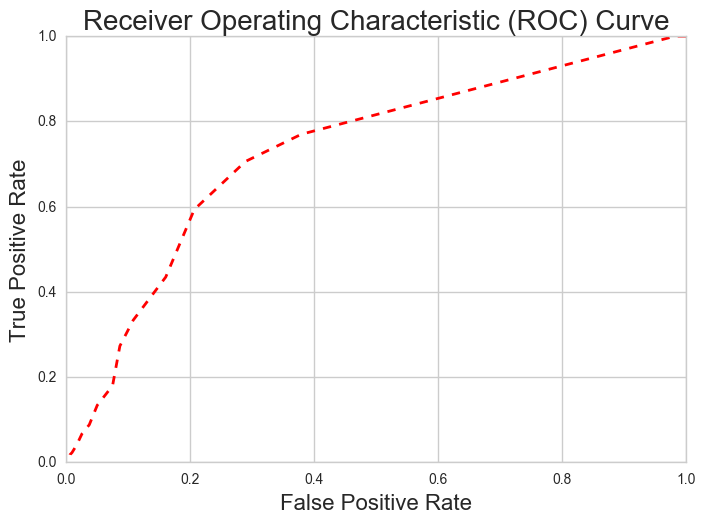

In [13]:
# The ideal ROC curve hugs the top left corner, indicating a high TPR and a low FPR. 
# A 45 degree line would represent the “no information” classifier: 
# our features cannot predict whether or not an email is spam.

#plt.figure(figsize=(10,8))
plt.plot(FPR, TPR, 'r--', lw=2)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=20)

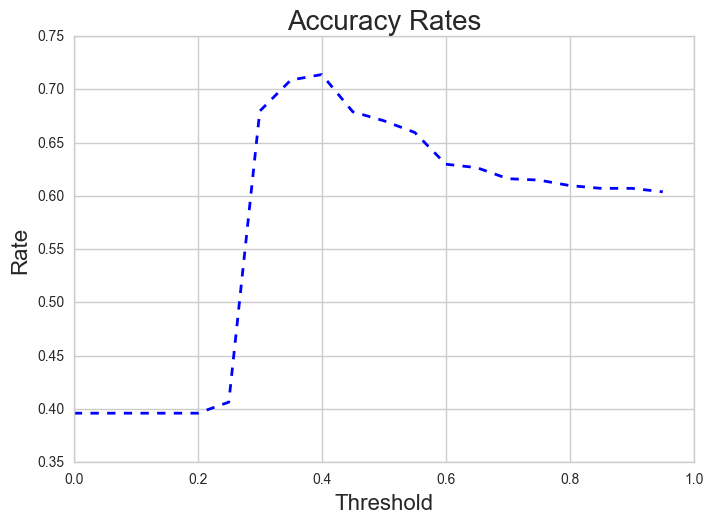

In [14]:
#plt.figure(figsize=(10,8))
plt.plot(scores, ACC, 'b--', lw=2)
#plt.xlim([0, 1])
#plt.ylim([0, 1])
plt.xlabel('Threshold', fontsize=16)
plt.ylabel('Rate', fontsize=16)
plt.title('Accuracy Rates', fontsize=20)

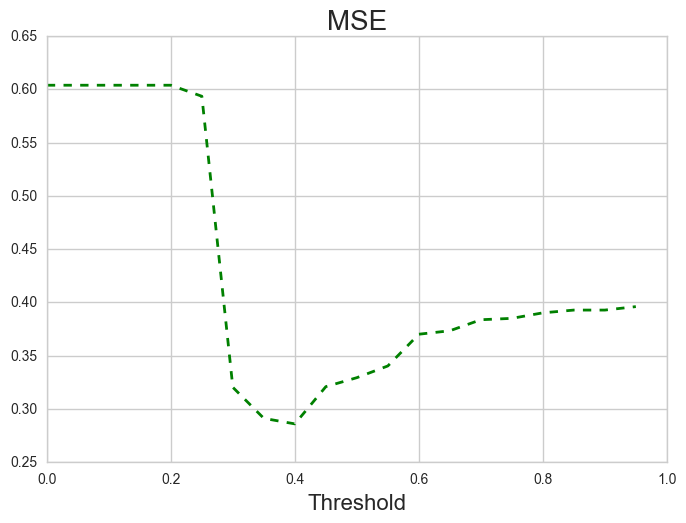

In [15]:
#plt.figure(figsize = (12,10))
plt.plot(scores, mse, 'g--', lw=2)
#plt.xlim([0, 1])
#plt.ylim([0, 1])
plt.xlabel('Threshold', fontsize=16)
#plt.ylabel('Rate', fontsize=16)
plt.title('MSE', fontsize=20)

## The K Nearest Neighbors (KNN) Classifier

KNN is a popular classification tool.  The name reflects exactly how the tool works (unlike many techniques in statistical learning).  Start with training data: [label, $x_1$, $x_2$].  For illustration purposes, set $K = 3$.  A candidate test data point with feature values $(x_{1j}, x_{2j})$ arrives.  The KNN predicator will determine the nearest three points in the training set based on a Euclidian distance metric.  Given the $known$ labels in the training set, the predictor will assign a label based on a majority vote.  (If $K$ is even, ties are determined by flipping a coin.)

The Euclidian distance between to two points, $(x_{1j}$, $x_{2j})$ and $(x_{1k}$, $x_{2k})$, is $\sqrt{(x_{1j} - x_{2j})^2 + (x_{1k} - x_{2k})^2}$

Let's start with a visualization to show how the KNN tool works.  

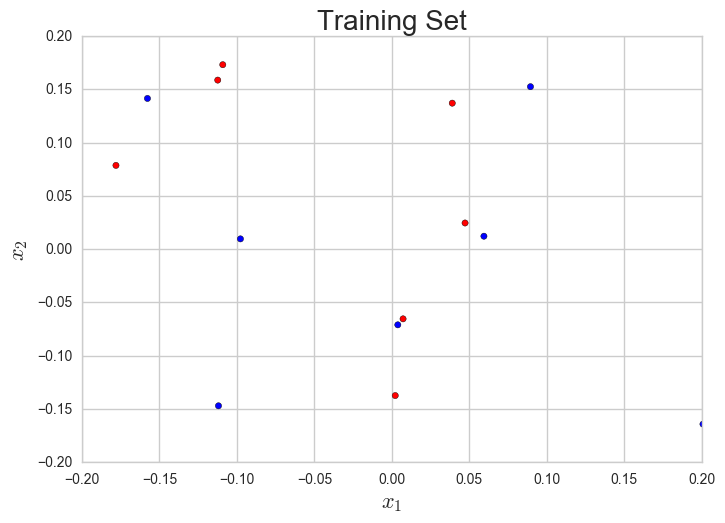

In [16]:
# Focus the scatterplot above onto a much smaller area.

#plt.figure(figsize = (12,10))
colors = ['red', 'blue']
plt.scatter(red, blue, c=colors)
plt.xlim(-0.2, 0.2)
plt.ylim(-0.2, 0.2)
plt.xlabel(r'$x_1$', fontsize = 16)
plt.ylabel(r'$x_2$', fontsize = 16)
plt.title(r'Training Set', fontsize = 20)

* Suppose the candidate value is (0.05, 0.10). What are the three nearest points in the training set? How would KNN classify?
* Suppose the candidate value is (0.00, -0.05). What are the three nearest points in the training set? How would KNN classify?

We obviously automate the process.

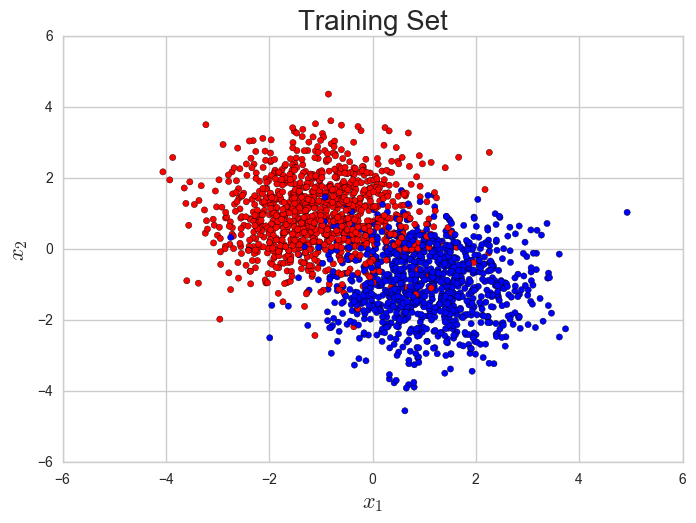

In [17]:
# Look again at the entire training set.

#plt.figure(figsize = (12,10))
colors = ['red', 'blue']
plt.scatter(red, blue, c=colors)
plt.xlim(-6, 6)
plt.ylim(-6, 6)
plt.xlabel(r'$x_1$', fontsize = 16)
plt.ylabel(r'$x_2$', fontsize = 16)
plt.title('Training Set', fontsize = 20)

In [18]:
# Combine original scatterplot data into a numpy array for scikit-learn.  
# This does not use Pandas as sklearn's algorithm needs numpy arrays.
# y is the label array, where 1 = red and 2 = blue (as dummy categories).
# X is the features array.

y1 = np.zeros((len(red),), dtype=np.int) + 1
y2 = np.zeros((len(blue),), dtype=np.int) + 2
y = np.append(y1, y2, axis=0)
X = np.append(red, blue, axis=0)

In [19]:
# Scikit-learn (sklearn) has a KNN algorithm, neighbors.KNeighborsClassifier, to which we pass K and the the distance metric.

# 'NN' is the number of nearest neighbors.
# 'how' is the metric used.  In the standard case, it is a Euclidean distance metric.
# 'point' is the feature values the KNN will classify.
# Start with obvious points (-2, 2), (2, -2) to confirm.
# (0.05, 0.10).  What are the three nearest points in the training set?  How would KNN classify?
# (0.00, -0.10).  What are the three nearest points in the training set?  How would KNN classify?

NN = 3
how = 'distance'
point = [0.0, -0.05]

# First line assigns the KNN object
# Second passes the object to the data for fitting and the predict.
knn = neighbors.KNeighborsClassifier(NN, how)
knn.fit(X, y)
print ("1 is Red, and 2 is Blue")
print ("KNN with %i Nearest Neighbors predicts" % (NN), knn.predict(point))

# Brief lab session.  Choose a number of different NN values and number of different points to obtain the KNN prediction.

1 is Red, and 2 is Blue
KNN with 3 Nearest Neighbors predicts [2]


* Choose a number of different NN values and number of different points to obtain the KNN prediction.

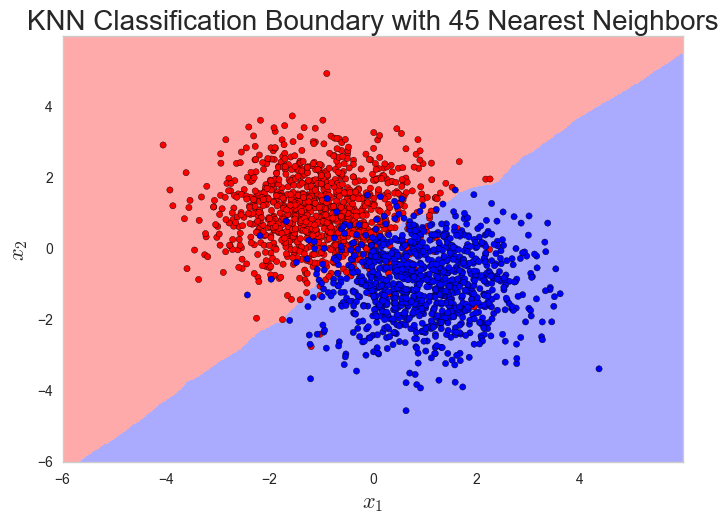

In [20]:
# Now we can consider predicting a massive number of candidates to map out the KNN classification boundary.  
# Rule of thumb on optimal K = sqrt(N), the size of the dataframe.
# Such a graph would allow us to assess the performance of the KNN algorithm.

# 'background' and 'dots' are background color and dot color based on http://matplotlib.org/api/colors_api.html.
# 'NN' is the number of nearest neighbors.
# 'how' is the metric used.  In the standard case, it is a Euclidean distance metric.
# 'h' is the step size for the mesh in the graph (h is often reserved as the value for cross-validation or step size).
background = ListedColormap(['#FFAAAA', '#AAAAFF'])
dots = ListedColormap(['#FF0000', '#0000FF'])
NN = 45
how = 'distance'
h = 0.02  

# Create the KNN object and then fit it to the data.  Useful to have the object itself.
knn = neighbors.KNeighborsClassifier(NN, how)
knn.fit(X, y)

# Scatterplot above set the plot range, which is used here.
x_min, x_max = -6, 6
y_min, y_max = -6, 6
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)
#plt.figure(figsize=(12, 10))
plt.pcolormesh(xx, yy, Z, cmap=background)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=dots)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("KNN Classification Boundary with %i Nearest Neighbors" % (NN), fontsize = 20)
plt.xlabel(r'$x_1$', fontsize = 16)
plt.ylabel(r'$x_2$', fontsize = 16)

In [21]:
# KNN can easily be expanded to a label with three categories, which has label 'green'.

random.seed(12345)
#red = np.random.multivariate_normal([-1, 1], [[1,0],[0,1]], 1000)
#blue = np.random.multivariate_normal([1, -1], [[1,0],[0,1]], 1000)
green = np.random.multivariate_normal([-2, -2], [[1,0],[0,1]], 1000)
y1 = np.zeros((len(red),), dtype=np.int) + 1
y2 = np.zeros((len(blue),), dtype=np.int) + 2
y3 = np.zeros((len(green),), dtype=np.int) + 3
y = np.append(y1, y2, axis=0)
y = np.append(y, y3, axis=0)
X = np.append(red, blue, axis=0)
X = np.append(X, green, axis=0)

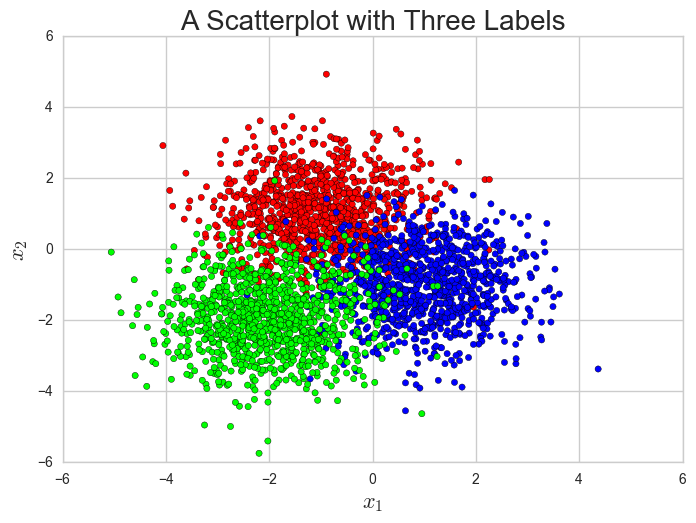

In [22]:
#plt.figure(figsize = (12,10))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap = ListedColormap(['#FF0000', '#0000FF', '#00FF00']))
plt.xlim(-6, 6)
plt.ylim(-6, 6)
plt.xlabel(r'$x_1$', fontsize = 16)
plt.ylabel(r'$x_2$', fontsize = 16)
plt.title(r'A Scatterplot with Three Labels', fontsize = 20)

In [23]:
NN = 25
how = 'distance'
point = [-4, 4]

knn = neighbors.KNeighborsClassifier(NN, how)
knn.fit(X, y)
print ("1 is Red, and 2 is Blue, and 3 is Green")
print ("KNN with %i Nearest Neighbors predicts" % (NN), knn.predict(point))

# Brief lab session.  Choose a number of different NN values and number of different points to obtain the KNN prediction.

1 is Red, and 2 is Blue, and 3 is Green
KNN with 25 Nearest Neighbors predicts [1]


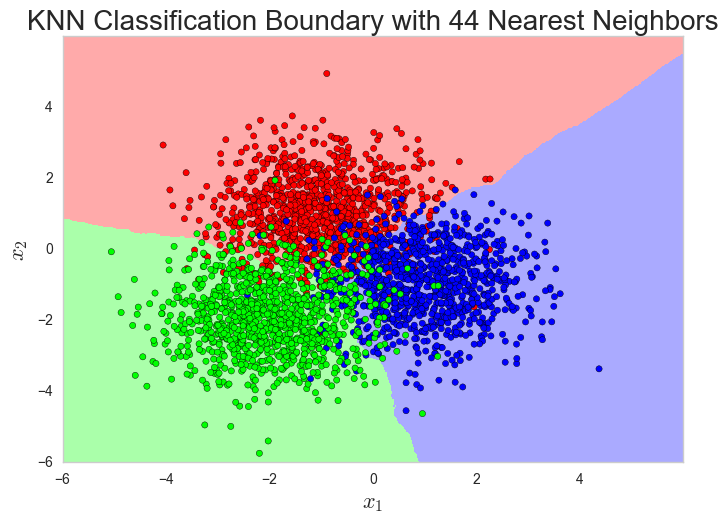

In [24]:
# Now we can consider predicting a massive number of candidates to map out the KNN classification boundary. 

# Set up inputs.
# background and dots are background color and dot color based on http://matplotlib.org/api/colors_api.html
# NN is the number of nearest neighbors
# how is the metric used.  In the standard case, it is an L2 distance metric.
# h is the step size for the mesh in the graph (h is often reserved as the value for cross-validation or step size).
background = ListedColormap(['#FFAAAA', '#AAAAFF', '#AAFFAA'])
dots = ListedColormap(['#FF0000', '#0000FF', '#00FF00'])
NN = 44
how = 'distance'
h = 0.02  

# Create the KNN object and then fit it to the data.  Useful to have the object itself.
knn = neighbors.KNeighborsClassifier(NN, how)
knn.fit(X, y)

# Scatterplot above set the plot range, which is used here.
x_min, x_max = -6, 6
y_min, y_max = -6, 6
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)
#plt.figure(figsize=(12, 10))
plt.pcolormesh(xx, yy, Z, cmap=background)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=dots)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("KNN Classification Boundary with %i Nearest Neighbors" % (NN), fontsize = 20)
plt.xlabel(r'$x_1$', fontsize = 16)
plt.ylabel(r'$x_2$', fontsize = 16)

This is Abalone


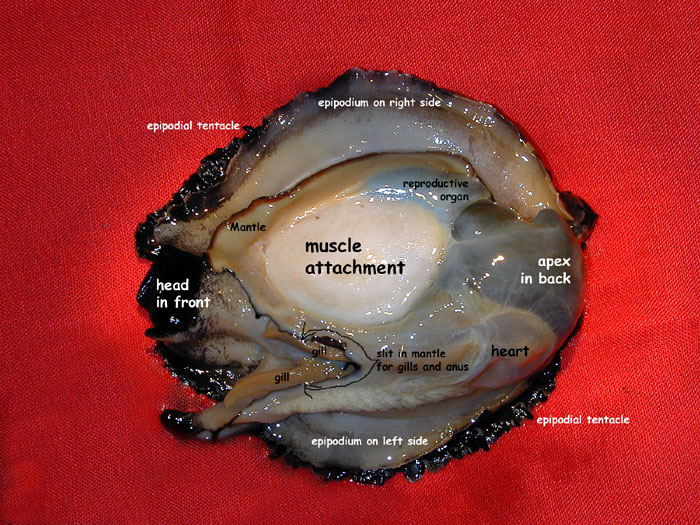

In [25]:
# Real world example.
# Use UCI archive again, this time with abalone.  
# Again, this is a curated dataset that has some key features, 
# namely that classification can be difficult.

# What's abalone?

from PIL import Image
import urllib.request as url
import io

print("This is Abalone")
fd = url.urlopen("http://www.marinebio.net/marinescience/06future/abimg/aa3770.jpg")
image_file = io.BytesIO(fd.read())
Image.open(image_file) 

In [26]:
target_url = ("http://archive.ics.uci.edu/ml/machine-"
              "learning-databases/abalone/abalone.data")

# Read abalone data from UCI repository.
abalone = pd.read_csv(target_url, header=None, prefix="v")
abalone.columns = ['Gender', 'Length', 'Diameter', 'Height', 'Whole Weight',
                   'Shucked Weight', 'Viscera Weight', 'Shell Weight',
                   'Rings']

# Gender is a alpha character rather than a numeric label.  Create a numeric label {1, 2, 3} for Gender
# to pass to various machine learning predictors.
abalone['Ind'] = np.zeros((len(abalone),), dtype=np.int) + 1
for i in range(len(abalone)):
    if abalone['Gender'][i]=='I': abalone['Ind'][i] += 1
    if abalone['Gender'][i]=='M': abalone['Ind'][i] += 2

# Note the use of pandas get_dummies, which cleaves off the [0, 1] from the logical expression.
np.random.seed(12345)
abalone['index'] = np.random.uniform(low = 0, high = 1, size = len(abalone))
abalone['test'] = pd.get_dummies(abalone['index'] <= 0.3333)[1]

# We don't need the index, so drop it.
del abalone['index']

# Now we can create new train and test dataframes.
# Note the format of these command lines.
# It basically resolves as create spamtest as a subset of spam when test is 1.
# Otherwise, it is train.
abalonetest = abalone[abalone['test'] == 1]
abalonetrain = abalone[abalone['test'] == 0]

# Confirm data has been split properly.
print (len(abalonetrain))
print (len(abalonetest))
print (len(abalone))

2791
1386
4177


In [27]:
# In Python, most of the classifiers come from Scikit-Learn (or sklearn).
# They do not use the Panda's dataframe, but instead use Numpy arrays.
# We need to generate Numpy arrays from the train and test dataframes, which is easy to do.

ytrain = abalonetrain['Ind'].as_matrix(columns=None)
ytest = abalonetest['Ind'].as_matrix(columns=None)

Xtrain = abalonetrain[['Length', 'Diameter', 'Height', 'Whole Weight', 'Shucked Weight', 
             'Viscera Weight', 'Shell Weight', 'Rings']].as_matrix(columns=None)
Xtest = abalonetest[['Length', 'Diameter', 'Height', 'Whole Weight', 'Shucked Weight', 
             'Viscera Weight', 'Shell Weight', 'Rings']].as_matrix(columns=None)

# Set NN at the sqrt(4177)
NN = 65
how = 'distance'
point = [abalonetrain.mean()[0], abalonetrain.mean()[1], abalonetrain.mean()[2], 
         abalonetrain.mean()[3], 
        abalonetrain.mean()[4], abalonetrain.mean()[5], abalonetrain.mean()[6], abalonetrain.mean()[7]]

knn = neighbors.KNeighborsClassifier(NN, how)
knn.fit(Xtrain, ytrain)
print ()
print ("1 is Female, 2 is Infant, and 3 is Male")
print ("KNN with %i Nearest Neighbors predicts" % (NN), knn.predict(point))


1 is Female, 2 is Infant, and 3 is Male
KNN with 65 Nearest Neighbors predicts [3]


In [28]:
# Now pass the test data to the KNN predictor to generate predictions.
# Evaluate the performance using confusion matrix, accuracy rate, and mean squared error.

ypred = knn.predict(Xtest)
cm = confusion_matrix(ytest, ypred)
KNNcm = cm
MSE = mean_squared_error(ytest, ypred)

ACC = (cm[0][0] + cm[1][1] +cm[2][2]) / (len(ypred))

table = [[" ","1", "2", "3"],
         ["1", cm[0][0], cm[0][1], cm[0][2]], 
         ["2", cm[1][0], cm[1][1], cm[1][2]], 
         ["3", cm[2][0], cm[2][1], cm[2][2]]]
print("The confusion matrix is:")
print(tabulate(table, tablefmt="fancy_grid", numalign = "center"))
print("The Accuracy Rate is", ACC)
print("The Mean Squared Error is", MSE)

The confusion matrix is:
╒═══╤═════╤═════╤═════╕
│   │  1  │  2  │  3  │
├───┼─────┼─────┼─────┤
│ 1 │ 147 │ 57  │ 234 │
├───┼─────┼─────┼─────┤
│ 2 │ 40  │ 368 │ 53  │
├───┼─────┼─────┼─────┤
│ 3 │ 170 │ 92  │ 225 │
╘═══╧═════╧═════╧═════╛
The Accuracy Rate is 0.533910533911
The Mean Squared Error is 1.34054834055


In [29]:
# What would a confusion matrix with random allocation look like?

ypred = np.random.permutation(ytest)
cm = confusion_matrix(ytest, ypred)
RANcm = cm
MSE = mean_squared_error(ytest, ypred)

ACC = (cm[0][0] + cm[1][1] +cm[2][2]) / (len(ypred))

table = [[" ","1", "2", "3"],
         ["1", cm[0][0], cm[0][1], cm[0][2]], 
         ["2", cm[1][0], cm[1][1], cm[1][2]], 
         ["3", cm[2][0], cm[2][1], cm[2][2]]]
print("The confusion matrix is:")
print(tabulate(table, tablefmt="fancy_grid", numalign = "center"))
print("The Accuracy Rate is", ACC)
print("The Mean Squared Error is", MSE)

The confusion matrix is:
╒═══╤═════╤═════╤═════╕
│   │  1  │  2  │  3  │
├───┼─────┼─────┼─────┤
│ 1 │ 146 │ 133 │ 159 │
├───┼─────┼─────┼─────┤
│ 2 │ 148 │ 159 │ 154 │
├───┼─────┼─────┼─────┤
│ 3 │ 144 │ 169 │ 174 │
╘═══╧═════╧═════╧═════╛
The Accuracy Rate is 0.345598845599
The Mean Squared Error is 1.31024531025


### Random Forest (RF) Classifier

The Random Forest Classifier is closely related to KNN because both classifiers identify a "weighted neighborhood" in the feature space, identify the known labels in that neighborhood (training set), and assign labels to unlabeled data (test set) based on a clear decision rule.  For KNN, it's majority rules with each point having the same weight.  For example, when $K=3$, KNN identifies the labels for the three closest points in the feature space.  If two are blue and one is red, the candidate receives a blue label.

In this context, the RF classifier has a more complicated method to build the weights based on decision trees.  It is an easy classifier to implement and has become very popular, in particular in classification of massive datasets because it is easy to parallelize the process. 

In a typical setting, 100 trees works.

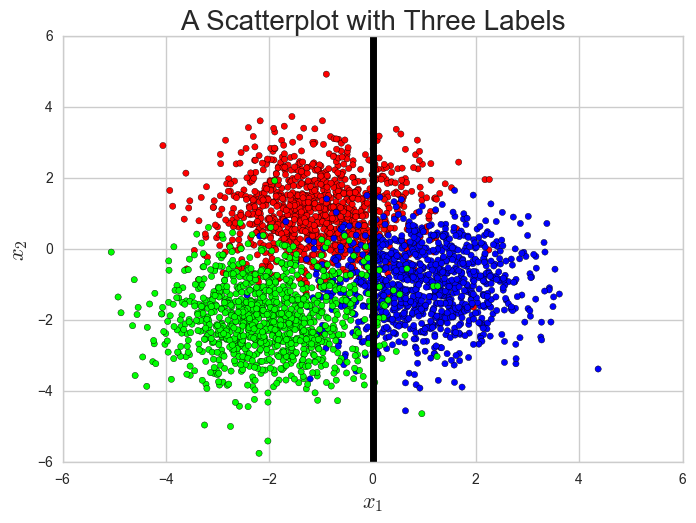

In [30]:
# A decision tree is similar to calling your bank and getting the automated teller, 
# which asks whether you're calling about a commercial or residential account;
# and then asks whether you're calling about a checking or savings account.
# A decision tree works in the identical manner by partitioning the feature space.
# The graphics below show the idea behind decision trees.
# Start by splitting the feature space at x1 = 0.
# Although this example is contrived, note that x1 > 0 predicts "blue" quite well.

#plt.figure(figsize = (10,8))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap = ListedColormap(['#FF0000', '#0000FF', '#00FF00']))
plt.xlim(-6, 6)
plt.ylim(-6, 6)
plt.xlabel(r'$x_1$', fontsize = 16)
plt.ylabel(r'$x_2$', fontsize = 16)
plt.title(r'A Scatterplot with Three Labels', fontsize = 20)
plt.axvline(x=0, linewidth=5, color='k')

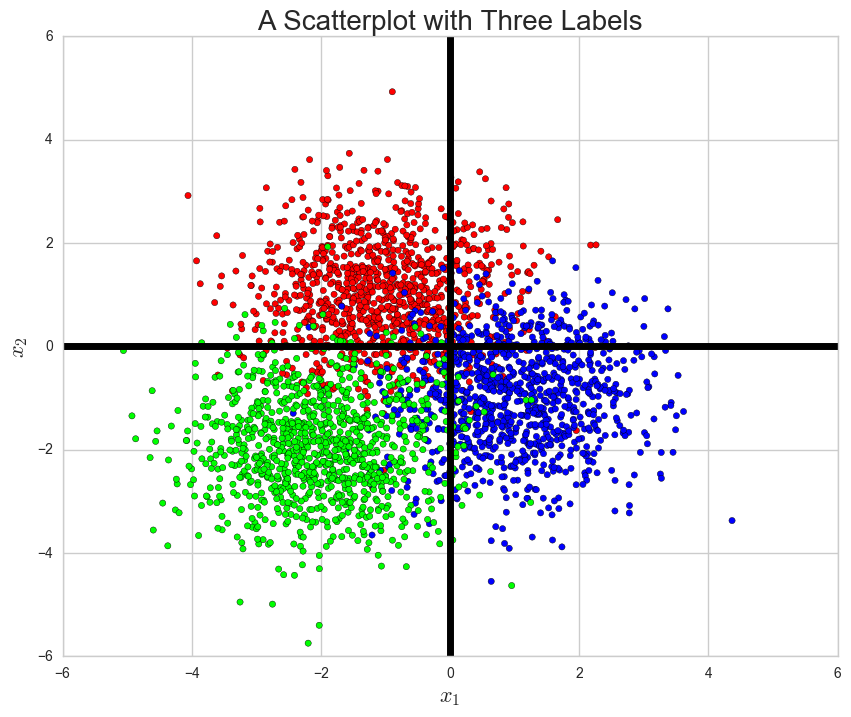

In [31]:
# Now split the the feature space at x2 = 0.
# This leads to a clear decision rule: green when x1 < 0 and x2 < 0; 
# red when x1 < 0 and x2 > 0; blue when x1 > 0 and x2 < 0; 
# continue the partition process when x1 > 0 and x2 > 0.
# For multiclass classification problems, the random forest is just a more sophisticated version of KNN 
# whereby nearer points have greater weight when the vote is taken.

plt.figure(figsize = (10,8))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap = ListedColormap(['#FF0000', '#0000FF', '#00FF00']))
plt.xlim(-6, 6)
plt.ylim(-6, 6)
plt.xlabel(r'$x_1$', fontsize = 16)
plt.ylabel(r'$x_2$', fontsize = 16)
plt.title(r'A Scatterplot with Three Labels', fontsize = 20)
plt.axvline(x=0, linewidth=5, color='k')
plt.axhline(y=0, linewidth=5, color='k')

In [32]:
# Notice the syntax.  First we assign the classifier to an object, then assign data, then make the prediction.

from sklearn.ensemble import RandomForestClassifier

np.random.seed(12345)
rf = RandomForestClassifier(n_estimators = 100)
rf.fit(Xtrain, ytrain)
ypred = rf.predict(Xtest)
cm = confusion_matrix(ytest, ypred)
RFcm = cm
MSE = mean_squared_error(ytest, ypred)

ACC = (cm[0][0] + cm[1][1] +cm[2][2]) / (len(ypred))

table = [[" ","1", "2", "3"],
         ["1", cm[0][0], cm[0][1], cm[0][2]], 
         ["2", cm[1][0], cm[1][1], cm[1][2]], 
         ["3", cm[2][0], cm[2][1], cm[2][2]]]
print("The confusion matrix is:")
print(tabulate(table, tablefmt="fancy_grid", numalign = "center"))
print("The Accuracy Rate is", ACC)
print("The Mean Squared Error is", MSE)

The confusion matrix is:
╒═══╤═════╤═════╤═════╕
│   │  1  │  2  │  3  │
├───┼─────┼─────┼─────┤
│ 1 │ 181 │ 52  │ 205 │
├───┼─────┼─────┼─────┤
│ 2 │ 40  │ 366 │ 55  │
├───┼─────┼─────┼─────┤
│ 3 │ 178 │ 90  │ 219 │
╘═══╧═════╧═════╧═════╛
The Accuracy Rate is 0.55266955267
The Mean Squared Error is 1.27633477633


### Comparing KNN and RF

In [33]:
# Comparing KNN, RF, and random designation.
# Remember that the on-diagonals are correctly classified.

print("1 is Female, 2 is Infant, and 3 is Male")
print("")
print("KNN Confusion Matrix")
print(KNNcm)
print()
print("RF Confusion Matrix")
print(RFcm)
print()
print("Random Confusion Matrix")
print(RANcm)

1 is Female, 2 is Infant, and 3 is Male

KNN Confusion Matrix
[[147  57 234]
 [ 40 368  53]
 [170  92 225]]

RF Confusion Matrix
[[181  52 205]
 [ 40 366  55]
 [178  90 219]]

Random Confusion Matrix
[[146 133 159]
 [148 159 154]
 [144 169 174]]


We have improved classifying Females, but do slightly worse at classifying Infants and Males.  It must be recognized, however, that both approaches are vastly superior to an algorithm of random assignment.  (Remember, we humans always have the ability to guess at random.  We program algorithms to improve on this process.)

### The Linear Discriminant Analysis (LDA) Classifier

We saw that the logit classifier is used for the two-class label: $\{$yes, no$\}$, $\{$on, off$\}$, or $\{$1, 0$\}$.  We  developed predictors based on test data by generating predicted probabilities for the training set and applying discriminant thresholds.  

Consider a less direct method to estimating these probabilities. 

In this alternative approach, we model the distribution of the features, $x_i$, separately in each of the label categories (technically, "given $y_i$").  We apply Bayes theorem of inverse probability to determine the probability an unlabel candidate is in category $j$ $conditional$ on the the data: Pr($y_i$ is in category $j$ | $x_i$).  Technically, when these distributions are
assumed to be normal and independent, it turns out that the model is very similar in form to logistic regression.

Why do we need another method when we have the logit classifier?

1. It another useful tool for our toolkit, in particular when we have more than two categories for the label.
2. When the categories are well-separated in the feature space, the logit classifier does not behave well.  This is because the logit likelihood surface is essentially flat.
3. Like RF (and unlike logit), this method scales with big data (because it can be parallelized).

In [34]:
from sklearn.lda import LDA

lda = LDA()
lda.fit(Xtrain, ytrain)
ypred = lda.predict(Xtest)
MSE = mean_squared_error(ytest, ypred)

cm = confusion_matrix(ytest, ypred)

ACC = (cm[0][0] + cm[1][1] +cm[2][2]) / (len(ypred))

table = [[" ","1", "2", "3"],
         ["1", cm[0][0], cm[0][1], cm[0][2]], 
         ["2", cm[1][0], cm[1][1], cm[1][2]], 
         ["3", cm[2][0], cm[2][1], cm[2][2]]]
print("The confusion matrix is:")
print(tabulate(table, tablefmt="fancy_grid", numalign = "center"))
print("The Accuracy Rate is", ACC)
print("The Mean Squared Error is", MSE)

The confusion matrix is:
╒═══╤═════╤═════╤═════╕
│   │  1  │  2  │  3  │
├───┼─────┼─────┼─────┤
│ 1 │ 129 │ 66  │ 243 │
├───┼─────┼─────┼─────┤
│ 2 │ 23  │ 360 │ 78  │
├───┼─────┼─────┼─────┤
│ 3 │ 116 │ 106 │ 265 │
╘═══╧═════╧═════╧═════╛
The Accuracy Rate is 0.544011544012
The Mean Squared Error is 1.23304473304


### The Multinomial Logit (MNL) Classifier

The multinominal logit (MNL) classifier is an extension of the logit classifier and is similar to the LDA classifier.  The MNL extends the logit model from a label with two categories to a label with multiple categories.  Here we estimate the multinomial logit using the training set and generate predicted probabilities for the test data.  The classification is simply the category with the highest predicted probability.  Oddly, this model is not use much outside of economics.  In part, unlike RF, it does not scale well with big data.  

Again we can look at the confusion matrix, accuracy rate, and mean squared error.

In [35]:
from statsmodels.discrete.discrete_model import MNLogit

endogtrain = abalonetrain['Ind']
exogtrain = abalonetrain[['Length', 'Diameter', 'Height', 'Whole Weight', 'Shucked Weight', 
             'Viscera Weight', 'Shell Weight', 'Rings']]
exogtest = abalonetest[['Length', 'Diameter', 'Height', 'Whole Weight', 'Shucked Weight', 
             'Viscera Weight', 'Shell Weight', 'Rings']]

mnlogit = MNLogit(endogtrain, exogtrain).fit()
print(mnlogit.summary())
print()
pred = np.array(mnlogit.predict(exogtest))

prediction = np.zeros((len(ypred),), dtype=np.int) + 3
for i in range(len(prediction)): 
    if pred[i][0] > pred[i][1] and pred[i][0] > pred[i][2]: prediction[i] = 1
    if pred[i][1] > pred[i][0] and pred[i][1] > pred[i][2]: prediction[i] = 2
        
cm = confusion_matrix(ytest, prediction)
MSE = mean_squared_error(ytest, prediction)

ACC = (cm[0][0] + cm[1][1] +cm[2][2]) / (len(ypred))

table = [[" ","1", "2", "3"],
         ["1", cm[0][0], cm[0][1], cm[0][2]], 
         ["2", cm[1][0], cm[1][1], cm[1][2]], 
         ["3", cm[2][0], cm[2][1], cm[2][2]]]
print("The confusion matrix is:")
print(tabulate(table, tablefmt="fancy_grid", numalign = "center"))
print("The Accuracy Rate is", ACC)
print("The Mean Squared Error is", MSE)

Optimization terminated successfully.
         Current function value: 0.859928
         Iterations 8
                          MNLogit Regression Results                          
Dep. Variable:                    Ind   No. Observations:                 2791
Model:                        MNLogit   Df Residuals:                     2775
Method:                           MLE   Df Model:                           14
Date:                Wed, 19 Apr 2017   Pseudo R-squ.:                  0.2148
Time:                        10:24:23   Log-Likelihood:                -2400.1
converged:                       True   LL-Null:                       -3056.5
                                        LLR p-value:                9.219e-272
         Ind=2       coef    std err          z      P>|z|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
Length            25.6111      3.246      7.889      0.000        19.248    31.974
Diameter         

### The Naive Bayes (NB) Classifier

The Naive Bayes Classifier uses Bayes' Theorem together with the naive assumption that, conditional on the label category, the value of a particular feature is independent of the value of any other feature.  In this situation, for example, Length is independent of Diameter, conditional on being Female.  Given this simplification, it simple to apply Bayes' Theorem to calculate posterior probabilties to predict a label (conditional on features).  While LDA assumes normal probability conditional on the label category (together with equal covariances), NB assumes features are independent conditional on the label category.

The NB classifier has worked well in real-world situations, including spam filtering. 

In [36]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(Xtrain, ytrain)
ypred = gnb.predict(Xtest)
MSE = mean_squared_error(ytest, ypred)

cm = confusion_matrix(ytest, ypred)

ACC = (cm[0][0] + cm[1][1] +cm[2][2]) / (len(ypred))

table = [[" ","1", "2", "3"],
         ["1", cm[0][0], cm[0][1], cm[0][2]], 
         ["2", cm[1][0], cm[1][1], cm[1][2]], 
         ["3", cm[2][0], cm[2][1], cm[2][2]]]
print("The confusion matrix is:")
print(tabulate(table, tablefmt="fancy_grid", numalign = "center"))
print("The Accuracy Rate is", ACC)
print("The Mean Squared Error is", MSE)

The confusion matrix is:
╒═══╤═════╤═════╤════╕
│   │  1  │  2  │ 3  │
├───┼─────┼─────┼────┤
│ 1 │ 265 │ 91  │ 82 │
├───┼─────┼─────┼────┤
│ 2 │ 34  │ 384 │ 43 │
├───┼─────┼─────┼────┤
│ 3 │ 273 │ 131 │ 83 │
╘═══╧═════╧═════╧════╛
The Accuracy Rate is 0.528138528139
The Mean Squared Error is 1.24025974026


### Our Classifiers and Their Performance

In [37]:
# KNN, RF, LDA, MNL, and NB Classifiers using Abalone data.  Let's bring this all together for ease of use.

NN = 65
how = 'distance'
ypred = knn.predict(Xtest)
cm = confusion_matrix(ytest, ypred)
knnACC = (cm[0][0] + cm[1][1] +cm[2][2]) / (len(ypred))
knnMSE = mean_squared_error(ytest, ypred)

rf = RandomForestClassifier(n_estimators = 20)
rf.fit(Xtrain, ytrain)
ypred = rf.predict(Xtest)
cm = confusion_matrix(ytest, ypred)
rfACC = (cm[0][0] + cm[1][1] +cm[2][2]) / (len(ypred))
rfMSE = mean_squared_error(ytest, ypred)

lda = LDA()
lda.fit(Xtrain, ytrain)
ypred = lda.predict(Xtest)
cm = confusion_matrix(ytest, ypred)
ldaACC = (cm[0][0] + cm[1][1] +cm[2][2]) / (len(ypred))
ldaMSE = mean_squared_error(ytest, ypred)

mnlogit = MNLogit(endogtrain, exogtrain).fit()
pred = np.array(mnlogit.predict(exogtest))
prediction = np.zeros((len(ypred),), dtype=np.int) + 3
for i in range(len(prediction)): 
    if pred[i][0] > pred[i][1] and pred[i][0] > pred[i][2]: prediction[i] = 1
    if pred[i][1] > pred[i][0] and pred[i][1] > pred[i][2]: prediction[i] = 2
cm = confusion_matrix(ytest, prediction)
mnlACC = (cm[0][0] + cm[1][1] +cm[2][2]) / (len(ypred))
mnlMSE = mean_squared_error(ytest, prediction)

gnb = GaussianNB()
gnb.fit(Xtrain, ytrain)
ypred = gnb.predict(Xtest)
cm = confusion_matrix(ytest, ypred)
nbACC = (cm[0][0] + cm[1][1] +cm[2][2]) / (len(ypred))
nbMSE = mean_squared_error(ytest, ypred)

# What would a confusion matrix with random allocation look like?

ypred = np.random.permutation(ytest)
cm = confusion_matrix(ytest, ypred)
ranACC = (cm[0][0] + cm[1][1] +cm[2][2]) / (len(ypred))
ranMSE = mean_squared_error(ytest, ypred)

Optimization terminated successfully.
         Current function value: 0.859928
         Iterations 8


In [38]:
# Here is the relative performance of our classifiers, including random guessing.

print('Accuracy of KNN, RF, LDA, MNL, NB, Guessing')
print(knnACC, rfACC, ldaACC, mnlACC, nbACC, ranACC)
print('')
print('MSE of KNN, RF, LDA, MNL, NB, Random, Guessing')
print(knnMSE, rfMSE, ldaMSE, mnlMSE, nbMSE, ranMSE)

Accuracy of KNN, RF, LDA, MNL, NB, Guessing
0.533910533911 0.528138528139 0.544011544012 0.562049062049 0.528138528139 0.320346320346

MSE of KNN, RF, LDA, MNL, NB, Random, Guessing
1.34054834055 1.33333333333 1.23304473304 1.18253968254 1.24025974026 1.35930735931


The obvious question is, "Which one to use?"  KNN, RF, LDA, and NB scale very nicely with massive data because the algorithms can be easily parallelized.  (For NB, this is because the naive assumption of independent allows the probabilities to be estimated independently.)  

In my experience, MNL does not scale well because the likelihood function cannot be parallelized (although it works very well on this particular classification problem).

### Lab

Using R or Python, read in spam dataset, and split into training and test sets.  Increasing the number of features used for ananlysis to the first 10 features, implement all the classifiers shown above.  Compare the accuracy and MSE of each method.  (Note that MNL in this case is just the logit classifier.)  You should do this as a separate R file or Jupyter notebook.

## Clustering

Clustering refers to a general set of techniques for finding subgroups, or clusters, in a dataframe.  When we cluster observations of a dataset, we seek to partition them into distinct groups so that the observations within each group are similar to each other, while observations in different groups are different from each other.  Frequently, we define what it means for two or more observations to be "similar" based on domain-specific considerations.

### What Is A Cluster?

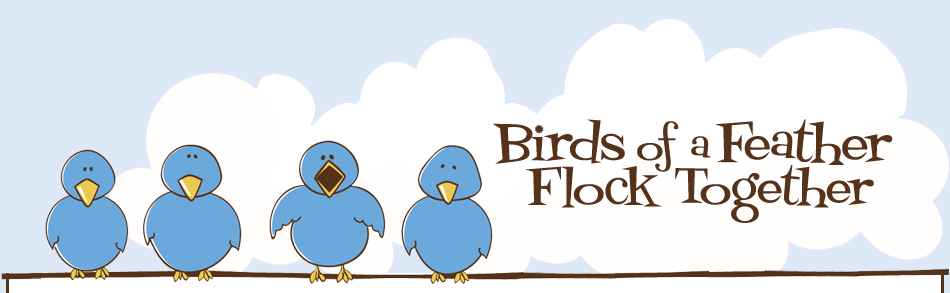

In [39]:
from PIL import Image
import urllib.request as url
import io

fd = url.urlopen("http://www.undergroundwineletter.com/wp-content/uploads/2012/01/birds-of-a-feather-cartoon.png")
image_file = io.BytesIO(fd.read())
Image.open(image_file)

Organizing the world into objects with similar features and applying labels to them is second nature to humans.  An object with four legs that is brown may be labelled a horse.  A small object with four legs that is brown may be labelled a dog.  This action is a form of clustering.

Clustering has proven to be an extraordinarily valuable tool.  Two overwhelmingly successful examples:

1. The periodic table of elements in chemistry.
2. The standard model of particle physics.

Clustering based on observed characteristics can, however, also be misleading.  For example, genetically a cow is more silimar to a whale than it is to a horse.  

In a dataframe, a cluster is a set of labels that are more similar to each other (with respect to their features) than to members of other clusters.  

We will implement a popular clustering algorithm, K-Means.

### K-Means Clustering

K-means clustering is a popular method to partition data into K distinct, mutually-exclusive clusters.  That is, each observation in a dataframe is assigned to $one$ and only $one$ cluster.  To perform K-means clustering, we must first specify the desired number of clusters, $K$, and the algorithm will assign each observation to a unique cluster number, $1,...,K$. 

A guiding principal behind K-means clustering is that a "good" set of clusters are those for which the within-cluster variation is as small as possible.  The within-cluster variation for cluster $C_k, k=1,...,K$, is a measure, $W(C_k)$, of the amount by which the observations within a cluster differ from each other.  

Formally, the algorithm:

${\displaystyle min_{C_1, ..., C_K} \sum_k W(C_k)}$ where the within variance is calculated using the Euclidian distance metric.

Recall that the Euclidian distance between to two points, $(x_{1j}$, $x_{2j})$ and $(x_{1k}$, $x_{2k})$, is $\sqrt{(x_{1j} - x_{2j})^2 + (x_{1k} - x_{2k})^2}$  The points can be in high dimensional space.

Algorithm

1. Randomly assigs a cluster number, $1,...,K$, to each of the $N$ observations in the dataframe, which serve as initial cluster assignments.
2. Compute a cluster "centroid" for each of the $K$ clusters.  The $k^{th}$ cluster centroid is a vector of the feature averages for the observations in the $k^{th}$ cluster.  
3. Assigns each observation to the cluster whose centroid is closest to it (in Euclidian distance).
4. Iterates the cluster assignments until they stop changing.

Some practical decisions with respect to cluster analysis:

1. Should the features ﬁrst be standardized in some way?  For instance, should the features be normalized to be mean zero and variance one?  
2. How many clusters should be used?

As with life, there is no free lunch.  There is no single "right" answer, and any solution that exposes interesting aspects of your data should be considered.  You might, for example, use training and test samples (if you have enough data) to examine how your decisions affect your results.

Let's conceptualize.

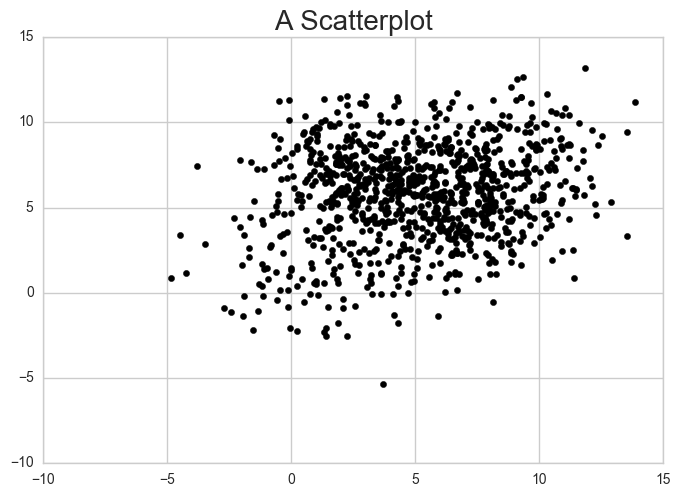

In [40]:
# Illustrate K-means clustering with synthetic data.
# Create four clusters and then add white noise.

np.random.seed(12345)
label = stats.binom.rvs(p = 0.5, n=3, size = 1000)
xc=np.array([1,7,3,9])
yc=np.array([1,5,7,9])
x=xc[np.array(label)] + stats.norm.rvs(0, 2, size = 1000)
y=yc[np.array(label)] + stats.norm.rvs(0, 2, size = 1000)
X=np.append(x, y).reshape(2, 1000).transpose()

#plt.figure(figsize=(8, 6))
plt.scatter(x, y, c = 'black')
plt.title('A Scatterplot', fontsize = 20)

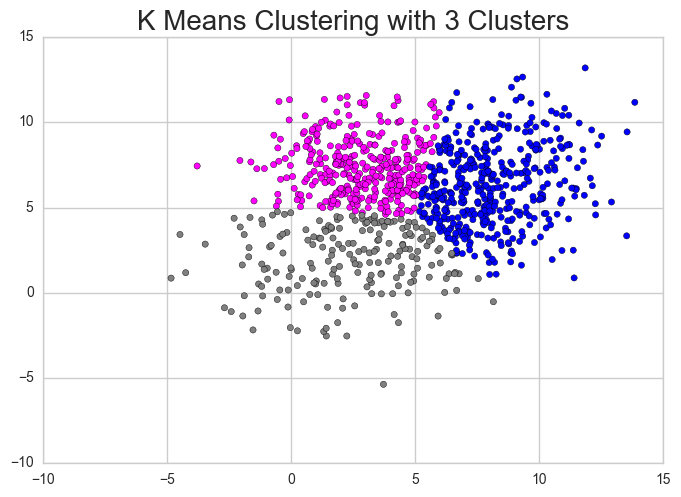

In [41]:
# Import KMeans from sklearn
# Import shapefile (pip install pyshp)
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
#import shapefile

# Start with two clusters and then increase.
k = 3

kmeans = KMeans(n_clusters = k, n_init = 100)
kmeans.fit(X)
colors = kmeans.labels_.astype(np.float) 
cmap = ListedColormap(['gray', 'red', 'green', 'blue', 'yellow', 'magenta'])
#cmap = 'flag'

#plt.figure(figsize=(8, 6))
plt.scatter(x, y, c=colors, cmap=cmap)
plt.title("K Means Clustering with %i Clusters" % (k), fontsize = 20)

### How Many Clusters?

To answer this question, we turn to the "Silhouette Score", called $S$, which is a measure of within-cluster similarity.

By construction, $S$ is bounded between -1 and 1, where 1 means that all within-cluster observations coinside perfectly with their cluster centroids.  This is equivalent to saying that there is zero with-in cluster variance for all clusters.  

Positive values of $S$ indicate that within-cluster observations are closer to their cluster centroids than they are to other cluster centroids.  

Values of $S$ near zero indicate that clustering is either inappropriate or unstable (that is, an alternative arrangement of the data into the same number of clusters would not decrease within-cluster variance). 

Typically, once you have invoked the k-means clustering algorithm, $S$ will be positive.

At 2 clusters, silhouette score is 0.36437314936647613
At 3 clusters, silhouette score is 0.3733728570798334
At 4 clusters, silhouette score is 0.37707984041381015
At 5 clusters, silhouette score is 0.334411463832445
At 6 clusters, silhouette score is 0.3297028291823592
At 7 clusters, silhouette score is 0.3275184851246007
At 8 clusters, silhouette score is 0.3310849349903425
At 9 clusters, silhouette score is 0.328875175343867


(0.2, 0.4)

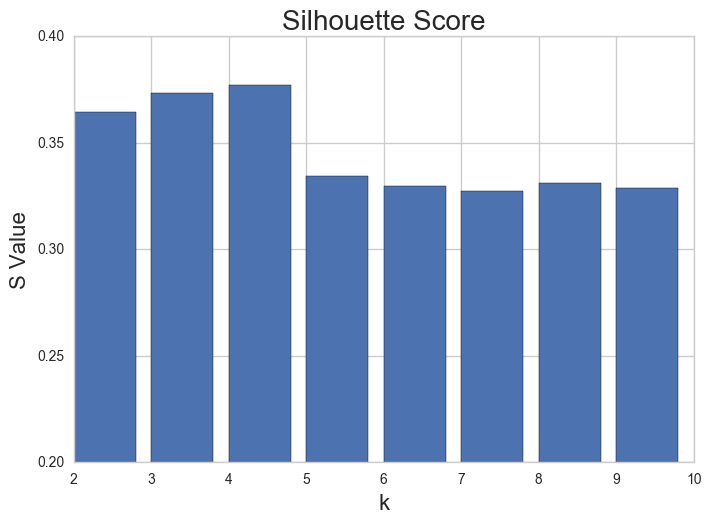

In [42]:
# Calculate S to evaluate the performance of clustering at different values of k.

s = np.zeros(8)
for k in range(0, 8):
    est = KMeans(n_clusters = k+2, n_init = 100)
    est.fit(X)
    s[k] = silhouette_score(X, est.labels_)
    print('At {0} clusters, silhouette score is {1}'.format(k+2, s[k]))
    
#plt.figure(figsize=(8, 6))
plt.bar(range(2, 10), s)
plt.xlabel('k', fontsize = 16)
plt.ylabel('S Value', fontsize = 16)
plt.title('Silhouette Score', fontsize = 20)
plt.ylim(.2, .4)

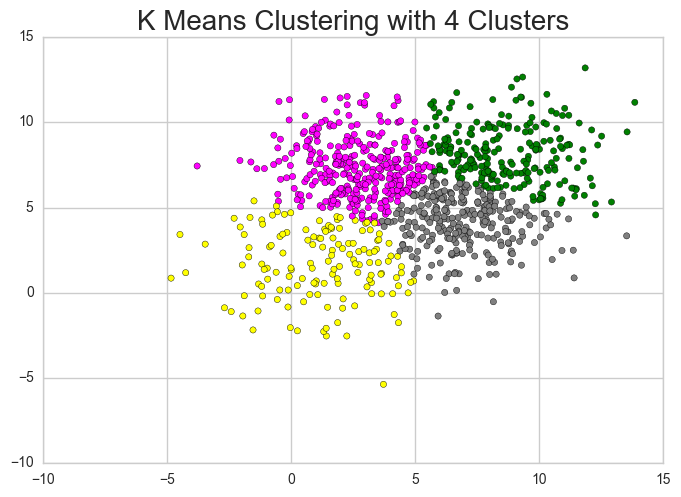

In [43]:
kopt = 4
kmeans = KMeans(n_clusters = kopt, n_init = 100)
kmeans.fit(X)
colors = kmeans.labels_.astype(np.float) 
#cmap = 'flag'
cmap = ListedColormap(['gray', 'red', 'green', 'blue', 'yellow', 'magenta'])

#plt.figure(figsize=(10,8))
plt.scatter(x, y, c=colors, cmap=cmap)
plt.title("K Means Clustering with %i Clusters" % (kopt), fontsize = 20)

### An Application of Clustering: Housing Density

In [44]:
# Grab Census data on all tracts in New York and create population and housing density as features.

url = 'http://www2.census.gov/geo/docs/maps-data/data/gazetteer/census_tracts_list_36.txt'
names = ['geo', 'pop', 'hu', 'land', 'water', 'landSqmi', 'waterSqmi', 'lat', 'long']
data = pd.read_table(url, header = 0, names = names)

data['popDensity'] = data['pop'] / data['landSqmi']
data['houseDensity'] = data['hu'] / data['landSqmi']

data = data.dropna()

In [45]:
data.head()

,geo,pop,hu,land,water,landSqmi,waterSqmi,lat,long,popDensity,houseDensity
NY,36001000100,2139,910,2367412,245155,0.914,0.095,42.663700,-73.736947,2340.262582,995.623632
NY,36001000200,6046,3103,2065211,0,0.797,0.000,42.664413,-73.751504,7585.947302,3893.350063
NY,36001000300,5888,3041,5781771,55326,2.232,0.021,42.680614,-73.783004,2637.992832,1362.455197
NY,36001000401,2227,1074,9017994,134151,3.482,0.052,42.705564,-73.864884,639.574957,308.443423
NY,36001000403,4415,2306,3136261,0,1.211,0.000,42.676872,-73.805276,3645.747316,1904.211396


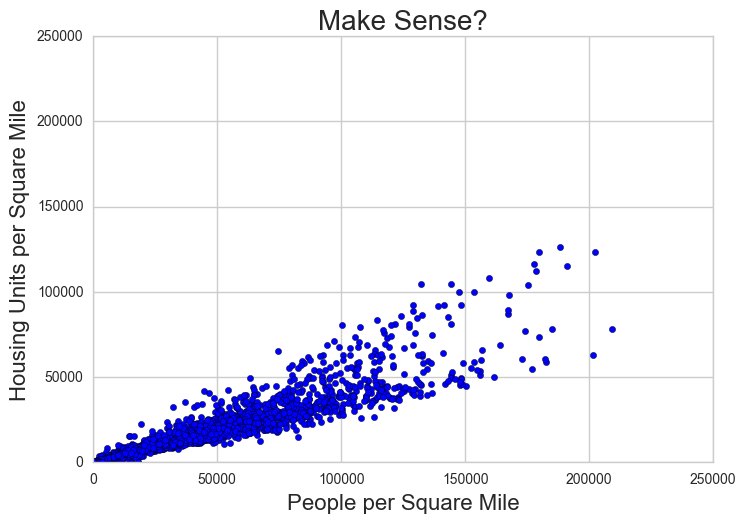

In [46]:
#plt.figure(figsize =(8, 6))
plt.scatter(data['popDensity'], data['houseDensity'], c = 'blue')
plt.xlim([0, 250000])
plt.ylim([0, 250000])
plt.xlabel('People per Square Mile', fontsize=16)
plt.ylabel('Housing Units per Square Mile', fontsize=16)
plt.title('Make Sense?', fontsize=20)

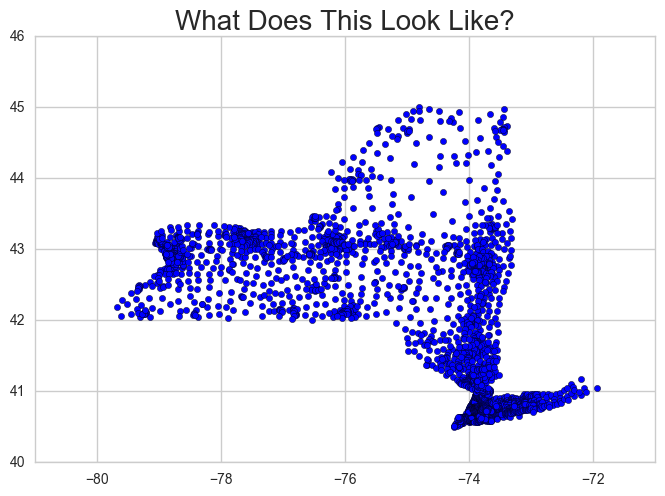

In [47]:
#plt.figure(figsize = (8, 6))
plt.scatter(data['long'], data['lat'], c = 'blue')
plt.title('What Does This Look Like?', fontsize = 20)

In [48]:
# For the k-mean algorithm, we need numpy arrays.
# Typically when clustering data such as these, one should normalize features to mean 0 and variance 1.
# You can confirm by unremarking last two lines.

X = data[['popDensity', 'houseDensity']].as_matrix(columns = None)
print(X.shape)

X = np.matrix(X)
m = np.mean(X, 0)
s = np.std(X, 0)
X = (X - m)/s
print(np.mean(X, 0))
print(np.var(X, 0))

(4900, 2)
[[ -2.58024894e-16   2.21267449e-15]]
[[ 1.  1.]]


In [49]:
# Use k means with 10 predetermined clusters.

k = 20

kmeans = KMeans(n_clusters = k, n_init = 100)
kmeans.fit(X)
colors = kmeans.labels_.astype(np.int) 
cmap = get_cmap("Spectral")

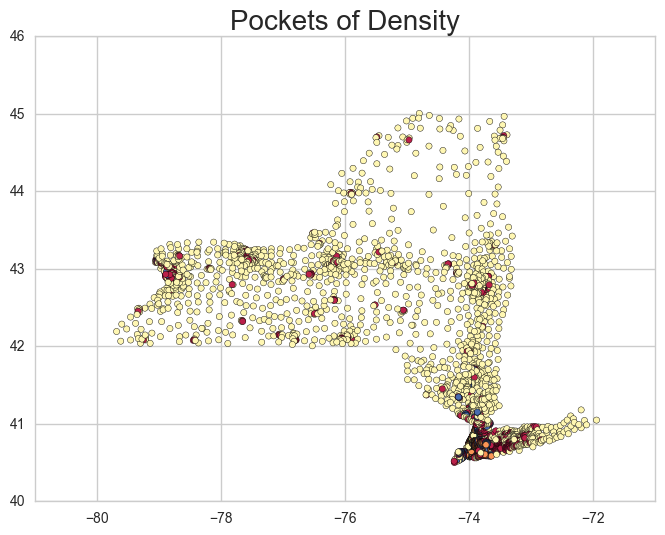

In [50]:
# Now graph clusters.  

plt.figure(figsize=(8, 6))
plt.scatter(data['long'], data['lat'], c = colors, cmap = cmap)
plt.title('Pockets of Density', fontsize = 20)

In [51]:
# Let's have some fun.
# Suppose one wanted geographically contiguous clusters.
# Give the k-means algorithm, it is simple to do using the latitude and longitude information.

X = data[['lat', 'long']].as_matrix(columns = None)
print(X.shape)

X = np.matrix(X)
m = np.mean(X, 0)
s = np.std(X, 0)
X = (X - m)/s
print(np.mean(X, 0))
print(np.var(X, 0))

(4900, 2)
[[ -9.04365018e-15   6.32634534e-14]]
[[ 1.  1.]]


In [52]:
# Use k means with 10 predetermined clusters.

k = 20

kmeans = KMeans(n_clusters = k, n_init = 100)
kmeans.fit(X)
colors = kmeans.labels_.astype(np.int) 
cmap = get_cmap("Spectral")

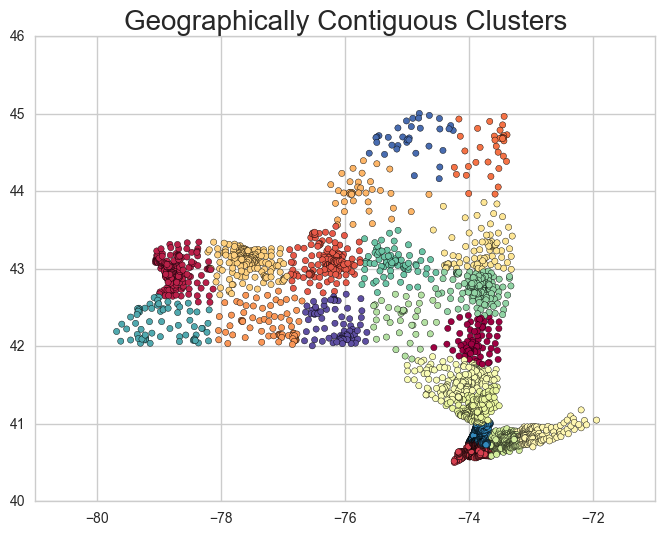

In [53]:
# Now graph clusters.  

plt.figure(figsize=(8, 6))
plt.scatter(data['long'], data['lat'], c = colors, cmap = cmap)
plt.title('Geographically Contiguous Clusters', fontsize = 20)

# What Is the Purpose of This?

1. Classification.  Clustering is a natural process of grouping items that are similar based on their features.  
2. Prediction.  Suppose I had features without a label attached.  One could use K-Means as a method to predict what the likeliest label is.

# Homework

1. Limit the dataframe to those Census tracts in NYC using the FIPs County Code embedded within the geo variable.  (This is a good exercise in manipulating dataframes.) Repeat the exercises above using k-means clustering.  Does NYC appear to you to be a mirror image of New York State?
2. Read in a dataframe of your from the NYC Open Data portal, https://opendata.cityofnewyork.us.  Use a number of different features to conduct a cluster analysis.  Determine the optimal number of clusters using the Silhouette Score and display your results visually.